# #30DayMapChallenge - Día 2: Líneas
## Caso de Negocio: El Costo Logístico de Conectar a México

**Autor:** Mario Ignacio Ibañez Castro | **Rol:** Data Scientist & Strategic Planner

### El Objetivo
En logística y Supply Chain, una línea en un mapa no es solo asfalto; es una **variable financiera**.

Para este segundo reto, analicé la **Red Nacional de Caminos (RNC)** del INEGI con un enfoque de costos operativos. El objetivo es visualizar la dicotomía de la infraestructura mexicana:
* **La Red Libre:** Extensa, capilar, pero lenta.
* **La Red de Cuota:** Selectiva, rápida, pero costosa.

**Pregunta de Negocio:** ¿Qué porcentaje de la infraestructura carretera está "privatizada" y cómo controla esto los ejes logísticos principales?

In [20]:
# Importamos las herramientas necesarias para el análisis espacial
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

# Configuramos el estilo visual en modo oscuro para resaltar los trazos neón
plt.style.use('dark_background')

In [ ]:
# Definimos la ruta al archivo Shapefile de la Red Nacional de Caminos
ruta_shp = r'C:\Users\mario\Documents\30DaysMapChallenge\Dia_2_lineas\00_Datos\conjunto_de_datos\red_vial.shp'

### 1. Ingesta de datos (ETL)
Utilizamos el Shapefile oficial de la Red Nacional de Caminos (INEGI). Dado que es un archivo vectorial pesado, optimizamos la carga leyendo únicamente las columnas críticas para el análisis: clasificación vial, peaje y geometría.

In [ ]:
# Leemos el archivo shapefile.
gdfp =gpd.read_file(ruta_shp)
display(gdfp.head())

,ID_RED,TIPO_VIAL,NOMBRE,CODIGO,COND_PAV,RECUBRI,CARRILES,ESTATUS,CONDICION,NIVEL,...,CIRCULA,ESCALA_VIS,VELOCIDAD,UNION_INI,UNION_FIN,LONGITUD,ANCHO,FECHA_ACT,CALIREPR,geometry
0,1,Periférico,Canal de Garay,N/A,N/A,N/A,3,Habilitado,En operación,0,...,Un sentido,1,80,325487,325488,180.734578,10.5,2024-06-17 21:10:00,Definida,"LINESTRING (-99.0643 19.3394, -99.06428 19.339..."
1,2,Periférico,Calle 7,N/A,N/A,N/A,2,Habilitado,En operación,0,...,Un sentido,1,50,325489,325490,51.475652,7.0,2022-05-03 19:09:38,Definida,"LINESTRING (-99.0521 19.43041, -99.05191 19.43..."
2,4,Periférico,Boulevard Adolfo López Mateos,N/A,N/A,N/A,2,Habilitado,En operación,0,...,Un sentido,1,50,325491,325492,324.396413,8.0,2023-09-04 00:00:00,Definida,"LINESTRING (-99.19358 19.4079, -99.19367 19.40..."
3,5,Calle,Ohio,N/A,N/A,N/A,3,Habilitado,En operación,0,...,Un sentido,2,30,325493,325494,142.119662,10.5,2023-07-24 17:50:54,Definida,"LINESTRING (-99.17238 19.39873, -99.17106 19.3..."
4,7,Avenida,Estrella,N/A,N/A,N/A,2,Habilitado,En operación,0,...,Dos sentidos,3,40,325495,325496,30.483697,7.0,2021-05-14 08:57:35,Definida,"LINESTRING (-99.28566 19.44935, -99.28582 19.4..."


### 2. Limpieza y filtrado estratégico
El dataset crudo contiene calles urbanas, caminos rurales y veredas que generan "ruido" visual. Para un análisis logístico primario, necesitamos filtrar exclusivamente las **Carreteras Pavimentadas**.

Además, normalizamos los tipos de datos para evitar errores de filtrado (un error común al trabajar con identificadores numéricos que se cargan como texto).

In [ ]:
# Para optimizar memoria, solo cargamos las columnas que vamos a utilizar:
gdf = gpd.read_file(ruta_shp, columns=['TIPO_VIAL', 'PEAJE', 'NOMBRE', 'geometry'])

# Validamos la carga imprimiendo las primeras 5 filas para entender la estructura
print(f"Dataset cargado con {len(gdf):,} registros.")
display(gdf.head())

Dataset cargado con 3,394,064 registros.


,NOMBRE,PEAJE,TIPO_VIAL,geometry
0,Canal de Garay,No,Periférico,"LINESTRING (-99.0643 19.3394, -99.06428 19.339..."
1,Calle 7,No,Periférico,"LINESTRING (-99.0521 19.43041, -99.05191 19.43..."
2,Boulevard Adolfo López Mateos,No,Periférico,"LINESTRING (-99.19358 19.4079, -99.19367 19.40..."
3,Ohio,No,Calle,"LINESTRING (-99.17238 19.39873, -99.17106 19.3..."
4,Estrella,No,Avenida,"LINESTRING (-99.28566 19.44935, -99.28582 19.4..."


In [ ]:
# Revisamos los tipos de datos para evitar errores al filtrar
print("\nInformación de las columnas:")
print(gdf.info())


Información de las columnas:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3394064 entries, 0 to 3394063
Data columns (total 4 columns):
 #   Column     Dtype   
---  ------     -----   
 0   NOMBRE     object  
 1   PEAJE      object  
 2   TIPO_VIAL  object  
 3   geometry   geometry
dtypes: geometry(1), object(3)
memory usage: 103.6+ MB
None


In [ ]:
# Inspeccionamos los valores únicos en TIPO_VIAL para saber qué código corresponde a 'Carretera'
# Esto nos ayuda a descartar caminos rurales o brechas que no son relevantes para logística primaria
print("Valores únicos en TIPO_VIAL antes de limpiar:")
print(gdf['TIPO_VIAL'].unique())

Valores únicos en TIPO_VIAL antes de limpiar:
['Periférico' 'Calle' 'Avenida' 'Circuito' 'Viaducto' 'Calzada' 'Eje vial'
 'Enlace' 'Retorno U' 'Boulevard' 'Carretera' 'Prolongación' 'Corredor'
 'Callejón' 'Glorieta' 'Camino' 'Privada' 'Cerrada' 'Andador' 'Otro'
 'Vereda' 'Diagonal' 'Rampa de frenado' 'Retorno' 'Peatonal' 'Ampliación'
 'Continuación' 'Circunvalación' 'Pasaje']


In [ ]:
# Estandarizamos la columna a texto (string) para asegurar que el filtro funcione correctamente
gdf['TIPO_VIAL'] = gdf['TIPO_VIAL'].astype(str)

In [ ]:
# Filtramos el dataset: Nos quedamos solo con TIPO_VIAL == '1' (Carreteras Pavimentadas)
gdf_carreteras = gdf[gdf['TIPO_VIAL'] == 'Carretera'].copy()

# Validamos que el filtrado haya funcionado revisando nuevamente los valores únicos
print(f"\nCarreteras filtradas: {len(gdf_carreteras):,} tramos.")
print("Validación de categoría única resultante:")
print(gdf_carreteras['TIPO_VIAL'].unique())


Carreteras filtradas: 328,034 tramos.
Validación de categoría única resultante:
['Carretera']


### 3. Segmentación: Costo vs. Cobertura
Aquí reside el núcleo del análisis. Separamos la red en dos capas lógicas:
1.  **Red de cuota (Peaje):** Representa velocidad y costo.
2.  **Red Libre:** Representa cobertura y ahorro.

In [ ]:
# Ahora separamos la red en dos categorías de negocio: Cuota (Peaje) vs. Libre
# Revisamos primero cómo viene codificada la columna PEAJE
print("\nValores en columna PEAJE:")
print(gdf_carreteras['PEAJE'].unique())


Valores en columna PEAJE:
['Si' 'No']


In [ ]:
# Creamos dos subconjuntos de datos
gdf_cuota = gdf_carreteras[gdf_carreteras['PEAJE'] == 'Si'].copy()
gdf_libre = gdf_carreteras[gdf_carreteras['PEAJE'] != 'Si'].copy()

# Corroboramos la cantidad de tramos en cada categoría
print(f"Tramos de Cuota identificados: {len(gdf_cuota):,}")
print(f"Tramos Libres identificados: {len(gdf_libre):,}")

Tramos de Cuota identificados: 18,784
Tramos Libres identificados: 309,250


In [ ]:
# Para calcular distancias reales en kilómetros, necesitamos reproyectar los datos.
# El sistema WebMercator (EPSG:3857) distorsiona las distancias, así que usamos
# una proyección métrica adecuada para México (ITRF2008 / EPSG:6362 o similar).
gdf_calc = gdf_carreteras.to_crs(epsg=6362)

### 4. Ingeniería de atributos: El KPI de privatización
Un Data Scientist no solo hace mapas, calcula métricas.
Para medir el impacto real, calculamos la longitud exacta en kilómetros.

**Nota técnica:** Es fundamental reproyectar los datos a un sistema métrico (como ITRF2008 o EPSG:6362) antes de calcular longitudes, ya que el sistema WebMercator distorsiona las distancias.

In [ ]:
# Calculamos la longitud de cada tramo en kilómetros
total_km = gdf_calc.length.sum() / 1000

# Hacemos lo mismo específicamente para la red de cuota
gdf_cuota_calc = gdf_calc[gdf_calc['PEAJE'] == 'Si']
km_cuota = gdf_cuota_calc.length.sum() / 1000

# Generamos el KPI de privatización de la red
porcentaje_cuota = (km_cuota / total_km) * 100

print(f"INSIGHTS DE NEGOCIO:")
print(f"Longitud Total de la Red Carretera Principal: {total_km:,.0f} km")
print(f"Longitud de la Red de Cuota: {km_cuota:,.0f} km")
print(f"Porcentaje de la red que requiere peaje: {porcentaje_cuota:.1f}%")

INSIGHTS DE NEGOCIO:
Longitud Total de la Red Carretera Principal: 196,747 km
Longitud de la Red de Cuota: 17,945 km
Porcentaje de la red que requiere peaje: 9.1%


In [ ]:
# Antes de graficar, convertimos ambas capas al sistema de coordenadas Web Mercator (EPSG:3857)
# Esto es obligatorio para poder superponer el mapa base de Contextily
gdf_libre_web = gdf_libre.to_crs(epsg=3857)
gdf_cuota_web = gdf_cuota.to_crs(epsg=3857)

### 5. Visualización
Finalmente, construimos el mapa. Utilizamos una paleta de colores contrastante:
* **Naranja/Rojo:** Para la red de cuota, denotando alerta/costo e importancia estratégica.
* **Azul:** Para la libre, denotando frialdad/bajo costo.

Integramos el KPI calculado (`9.1%`) directamente en el subtítulo para que el mapa se explique por sí solo.

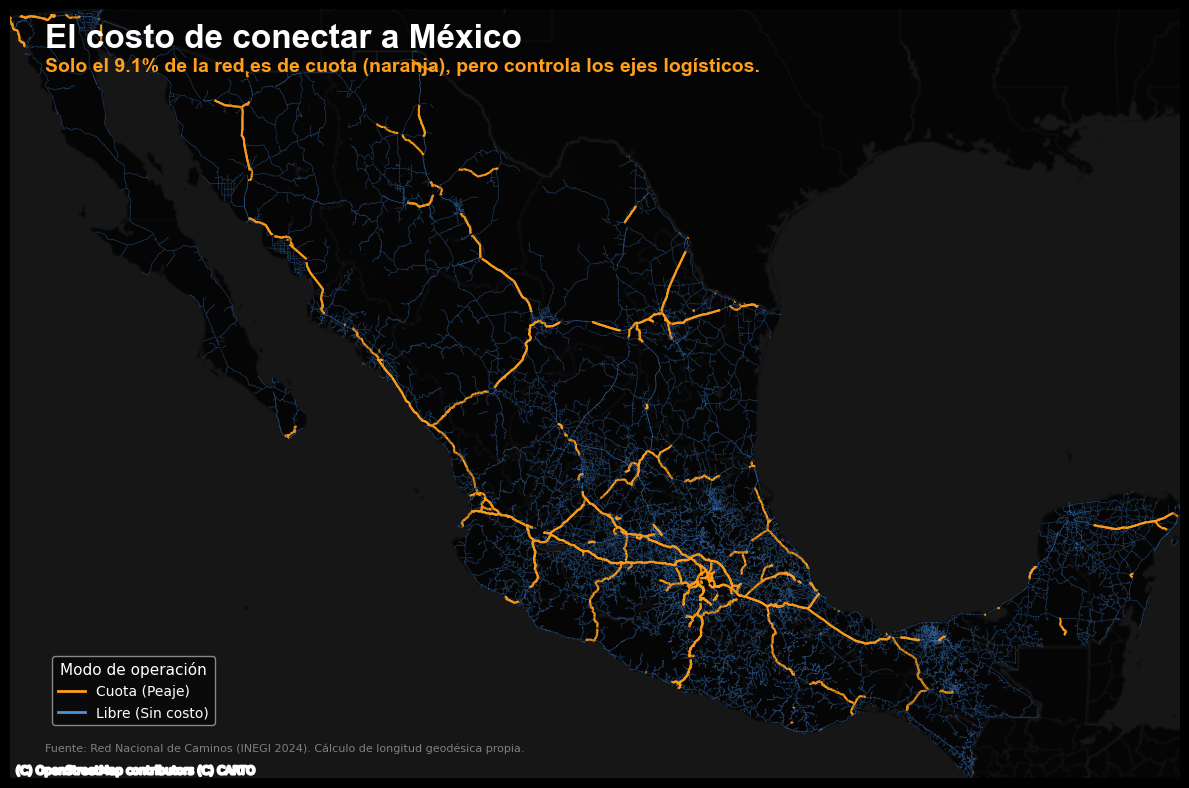

Visualización generada exitosamente: Dia2_Lineas_Logistica.png


In [ ]:
# Configuramos el lienzo de la gráfica
fig, ax = plt.subplots(figsize=(12, 12))
fig.patch.set_facecolor('black')

# Graficamos la capa de contexto: Carreteras Libres
# Usamos un color azul tenue y transparencia para que sirvan de referencia sin saturar
gdf_libre_web.plot(
    ax=ax,
    linewidth=0.5,
    color='#4A90E2',
    alpha=0.4,
    zorder=1,
    label='Libre'
)

# Graficamos la capa de interés: Carreteras de Cuota
# Usamos rojo neón y mayor grosor para destacar los corredores logísticos de alto costo
gdf_cuota_web.plot(
    ax=ax,
    linewidth=1.5,
    color='#FF9F1C',
    alpha=1.0,
    zorder=2,
    label='Cuota'
)

# Calculamos el encuadre automático basado en nuestros datos para centrar el mapa
bounds = gdf_carreteras.to_crs(epsg=3857).total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Añadimos el mapa base oscuro para dar contexto geográfico (fronteras, costas)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels, zoom_adjust=0, alpha=0.6)

# Agregamos los elementos narrativos
# Título principal con la pregunta de negocio
ax.text(
    x=0.03, y=0.95,
    s="El costo de conectar a México",
    transform=ax.transAxes, fontsize=24, fontweight='bold', color='white', fontname='Arial'
)

# Subtítulo dinámico integrando el KPI que calculamos previamente
ax.text(
    x=0.03, y=0.92,
    s=f"Solo el {porcentaje_cuota:.1f}% de la red es de cuota (naranja), pero controla los ejes logísticos.",
    transform=ax.transAxes, fontsize=14, color='#FF9F1C', fontname='Arial', fontweight='bold'
)

# Leyenda personalizada
from matplotlib.lines import Line2D
# Creamos elementos gráficos manuales para tener control total del diseño
legend_elements = [
    Line2D([0], [0], color='#FF9F1C', lw=2, label='Cuota (Peaje)'),
    Line2D([0], [0], color='#4A90E2', lw=2, label='Libre (Sin costo)')
]

# Añadimos la leyenda al mapa
ax.legend(
    handles=legend_elements,
    loc='lower left',           # Posición base: Abajo Izquierda
    bbox_to_anchor=(0.03, 0.06),# Ajuste fino (x, y) para subirla un poco y no tapar la fuente
    fontsize=10,
    frameon=True,               # Caja activada
    facecolor='black',          # Fondo negro para la caja
    edgecolor='white',          # Borde blanco fino
    framealpha=0.5,             # Un poco de transparencia
    labelcolor='white',         # Texto blanco
    title='Modo de operación',# Título de la leyenda
    title_fontsize=11
)

# Nota al pie con la fuente de datos y metodología
ax.text(
    x=0.03, y=0.035,
    s="Fuente: Red Nacional de Caminos (INEGI 2024). Cálculo de longitud geodésica propia.",
    transform=ax.transAxes, fontsize=8, color='gray'
)

# Eliminamos los ejes para limpiar la visualización
ax.set_axis_off()
plt.tight_layout()

# Guardamos la imagen final en alta resolución
output_file = 'Dia2_Lineas_Logistica.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='black')
plt.show()

print(f"Visualización generada exitosamente: {output_file}")

In [ ]:
!jupyter nbconvert --to pdf "Dia 2_Lineas.ipynb"

[NbConvertApp] Converting notebook Dia 2_Lineas.ipynb to pdf
[NbConvertApp] Support files will be in Dia 2_Lineas_files\
[NbConvertApp] Making directory .\Dia 2_Lineas_files
[NbConvertApp] Writing 48786 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 478031 bytes to Dia 2_Lineas.pdf
